**Importing libraries for the model**

import the basic libraries to work with dataframes and arrays

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ema related imports

In [4]:
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, perform_experiments, ema_logging, ScalarOutcome)

In [5]:
from ema_workbench.em_framework.evaluators import SOBOL
from ema_workbench.em_framework.samplers import sample_uncertainties, sample_levers
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
import functools

In [6]:
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

**Preparing optimization with MORDM results, constraints and the robustness function**

In [7]:
#results from the MORDM optimization in the final assignment file
results_optimize_MORDM = pd.read_csv('results_optimize_MORDM_1.csv')

In [8]:
#the outlook of the dataframe constructed with the MORDM outcomes
results_optimize_MORDM.head()

,Unnamed: 0,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat,All Costs,Total Investment Costs,Expected Annual Damage,Total Number of Deaths,Dike Investment Costs,RfR Total Costs,Expected Evacuation Costs
0,0,10,10,5,6,10,0,1,1,0,0,1,4.965628e+08,4.637975e+08,3.276525e+07,0.011439,2.152967e+08,248500000.0,823.529306
1,1,8,10,10,5,2,0,1,0,0,1,2,1.125335e+09,6.701002e+08,4.552352e+08,0.052768,1.961782e+08,473900000.0,22012.341826
2,2,10,8,0,0,1,1,1,0,0,0,2,1.808547e+09,4.567516e+08,1.351795e+09,0.237329,1.542958e+08,302400000.0,55801.315168
3,3,10,8,1,9,4,1,1,0,0,0,4,1.139498e+09,4.947391e+08,6.447586e+08,0.098435,1.923033e+08,302400000.0,35741.990555
4,4,10,10,4,5,1,1,1,1,0,0,0,1.064519e+09,5.288389e+08,5.356797e+08,0.425323,1.957389e+08,333100000.0,0.000000


In [9]:
#retreiving the lowest/worst 3 quartiles for all objectives
#this is used to set the boundaries
#it functions as selecting the cases of interest with a size of 75%
#dumps the best performing quartile
death_optimize_constrain = np.percentile(results_optimize_MORDM['Total Number of Deaths'],75)
annualdamage_optimize_constrain = np.percentile(results_optimize_MORDM['Expected Annual Damage'],75)
totalinvestment_optimize_constrain = np.percentile(results_optimize_MORDM['Total Investment Costs'],75)
allcosts_optimize_constrain = np.percentile(results_optimize_MORDM['All Costs'],75)
dike_optimize_constrain = np.percentile(results_optimize_MORDM['Dike Investment Costs'],75)
rfr_optimize_constrain = np.percentile(results_optimize_MORDM['RfR Total Costs'],75)
evacuation_optimize_constrain = np.percentile(results_optimize_MORDM['Expected Evacuation Costs'],75)

In [10]:
#robustness function, changing the objection directions to what Rijkswaterstaat prefers.
def robustness(direction, threshold, data):
    #making clear the direction is correctly implemented
    #mostly needed in case any of the objectives would be maximized as all are minimized now.
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'
LARGER = 'LARGER'

moro_investment = functools.partial(robustness, SMALLER, totalinvestment_optimize_constrain)
moro_annual_damage = functools.partial(robustness, SMALLER, annualdamage_optimize_constrain)
moro_death = functools.partial(robustness, SMALLER, death_optimize_constrain)
moro_dike = functools.partial(robustness, SMALLER, dike_optimize_constrain)
moro_rfr = functools.partial(robustness, SMALLER, rfr_optimize_constrain)
moro_evacuation = functools.partial(robustness, SMALLER, evacuation_optimize_constrain)

In [11]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

#creating the objectives to match the type of outcome wanted
#the objectives are defined as scalaroutcomes
#the intended direction for optimization is added
robustnes_functions = [ScalarOutcome('total investment', kind=MINIMIZE, 
                             variable_name='Total Investment Costs', function=moro_investment),
                       ScalarOutcome('annual damage', kind=MINIMIZE, 
                             variable_name='Expected Annual Damage', function=moro_annual_damage),
                       ScalarOutcome('expected death', kind=MINIMIZE, 
                             variable_name='Total Number of Deaths', function=moro_death),
                      ScalarOutcome('dike investment', kind=MINIMIZE, 
                             variable_name='Dike Investment Costs', function=moro_dike),
                      ScalarOutcome('RfR Investment', kind=MINIMIZE, 
                             variable_name='RfR Total Costs', function=moro_rfr),
                      ScalarOutcome('Evacuation Costs', kind=MINIMIZE, 
                             variable_name='Expected Evacuation Costs', function=moro_evacuation)]

**Using MORO for optimization**

In [12]:
#importing the problem_formulation function from the python file
from problem_formulation_2 import get_model_for_problem_formulation

ModuleNotFoundError: No module named 'dike_model_function'

In [17]:
#the newly defined problem formulation from the problem formulation file
#this problem formulation specifies the outcomes of interest
dike_model = get_model_for_problem_formulation(4)

In [18]:
#creating the number of scenarios and reference scenario for optimization with moro
n_scenarios_moro = 50
ref_scenarios_moro = sample_uncertainties(dike_model, n_scenarios_moro)

In [22]:
#logging function to track the progress of the moro optimization
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [26]:
#setting boundaries
convergence_value = [HyperVolume(minimum=[0,0,0,0,0,0], maximum=[1.1,1.1,1.1,1.1,1.1,1.1]),
               EpsilonProgress()]

#The number of iterations/function evaluations the optimization uses
nfe = 3000

#optimization processs with all results and experiments being stored in two variables
#namely archive_moro and convergence_moro
#setting the epsilons to 0.05. This can be seen as the accuracy required by the optimization
with MultiprocessingEvaluator(dike_model) as evaluator:
    archive_moro, convergence_moro = evaluator.robust_optimize(robustnes_functions, ref_scenarios_moro, 
                                               nfe=nfe, convergence=convergence_value,
                                               epsilons=[0.05,0.05,0.05,0.05,0.05,0.05]*len(robustnes_functions))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/3000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 1667 cases completed
[MainProcess/INFO] 3334 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/3000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 1667 cases completed
[MainProcess/INFO] 3334 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/3000 nfe
[MainProcess/INFO] performing 50 scenarios * 97 policies * 1 model(s) = 4850 experiments
[MainProcess/INFO] 1617 cases completed
[MainProcess/INFO] 3234 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 297/3000 nfe
[MainProcess/INFO] performing 50 scenarios * 100 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 1667 cases completed
[MainProcess/INFO] 3334 cas

[MainProcess/INFO] 3066 cases completed
[MainProcess/INFO] 4599 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 30: 2940/3000 nfe
[MainProcess/INFO] performing 50 scenarios * 95 policies * 1 model(s) = 4750 experiments
[MainProcess/INFO] 1583 cases completed
[MainProcess/INFO] 3166 cases completed
[MainProcess/INFO] 4749 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] optimization completed, found 5 solutions
[MainProcess/INFO] terminating pool


In [27]:
#the most promising policies given the optimization above
archive_moro

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat,total investment,annual damage,expected death,dike investment,RfR Investment,Evacuation Costs
0,0,9,0,1,1,0,1,0,1,1,3,1.0,1.0,1.00,1.0,0.0,0.98
1,1,0,0,0,5,0,1,0,0,1,0,1.0,1.0,0.68,1.0,1.0,1.00
2,10,10,0,4,1,0,1,0,1,1,0,0.0,1.0,0.84,0.0,0.0,1.00
3,9,10,0,3,8,1,1,0,0,1,0,0.0,1.0,0.78,0.0,1.0,1.00
4,0,0,0,5,0,0,1,0,1,1,0,1.0,1.0,0.76,1.0,0.0,1.00


In [28]:
#creating the csv of those promising policies in the same folder
archive_moro.to_csv('policies.csv')

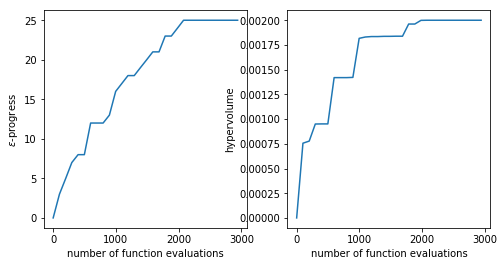

In [31]:
#creating subplots reporting change in the epsilon
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence_moro.nfe, convergence_moro.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence_moro.nfe, convergence_moro.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [36]:
#creating a set of list of all policies and their respective outcomes for the policies
policies_moro = [Policy("policy_1", **archive_moro.to_dict('records')[0]),
             Policy("policy_2", **archive_moro.to_dict('records')[1]),
             Policy("policy_3", **archive_moro.to_dict('records')[2]),
             Policy("policy_4", **archive_moro.to_dict('records')[3]),
             Policy("policy_5", **archive_moro.to_dict('records')[4])]
            

In [37]:
#
n_scenarios_moro_open = 400
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_moro_open = evaluator.perform_experiments(n_scenarios_moro_open, policies_moro)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 400 scenarios * 5 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


**Visualizing the different policies**

In [38]:
#importing seaborn
import seaborn as sns

C:\Users\Dave\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [40]:
#unpacking the results into two storage variables
#the first a ndarray the latter as a dictionarry
experiments, outcomes = results_moro_open

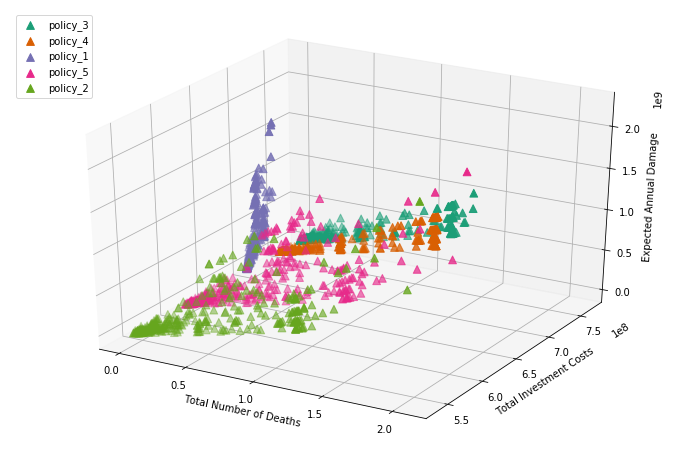

In [59]:
#importing the plotting tools to create a 3d stacking plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = sns.color_palette('Dark2', 5)
markers = ['o', '^']
oois = ['Total Number of Deaths', 'Total Investment Costs','Expected Annual Damage']

#setting the axis of the 3d plot with the aformentioned performance indicators/objectives
ax.set_xlabel(oois[0])
ax.set_ylabel(oois[1])
ax.set_zlabel(oois[2])

#looping through the assessed combinations of the policy levers in the experiments
for p, policy in enumerate(set(experiments['policy'])):
    #selecting based on policy to form grouping in the plot
    logical = experiments['policy']==policy
    new_outcomes = {key:value[logical] for key, value in outcomes.items()}
    new_experiments = experiments[logical]
    
    #logical_index = (new_outcomes['infected fraction R1'][:, 99]>0.1) &\
     #               (new_experiments['infection ratio region 1']>0.1)
    
    #x_ = new_outcomes[oois[0]][logical_index]
    x = new_outcomes[oois[0]]
    
   # y_ = new_outcomes[oois[1]][logical_index,-1]
    y = new_outcomes[oois[1]]
    
   # z_ = new_outcomes[oois[2]][logical_index]
    z = new_outcomes[oois[2]]
    
    ax.scatter(x, y, z, c=colors[p], marker=markers[1], s=60, label=policy)
    #ax.scatter(x_, y_, z_, c=colors[p], marker=markers[1], s=60, label=policy+'*')

ax.legend(loc=2, scatterpoints = 1)
#ax.set_xlim([0, 0.5])
#ax.set_ylim([0, 5e+07])
#ax.set_zlim([0, 50])
fig.set_figheight(8)
fig.set_figwidth(12)

plt.show()

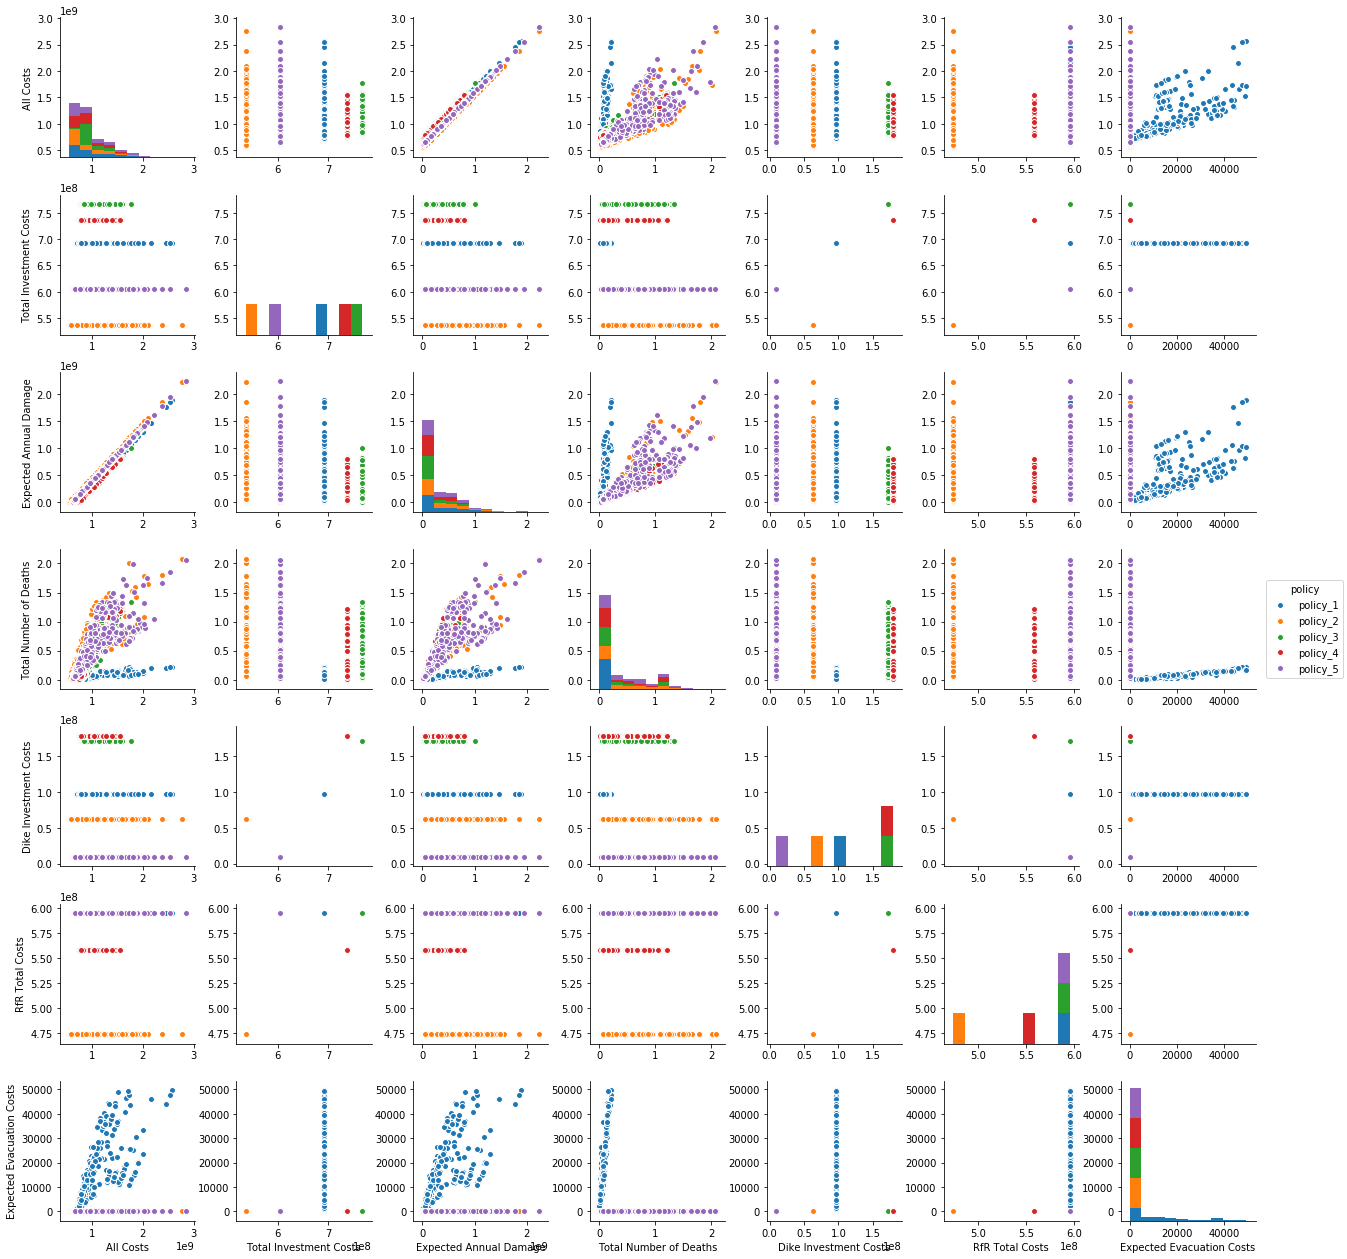

In [47]:
# Show in dimensional stacking
df = pd.DataFrame.from_dict(outcomes)
df = df.assign(policy=experiments['policy'])
 
# use seaborn to plot the dataframe
grid = sns.pairplot(df, hue='policy', vars=outcomes.keys())
ax = plt.gca()
plt.show()

In [1]:
#changing structured arrays require this library
import numpy.lib.recfunctions as rf

In [2]:
#cleaning experiments to only contain useful information to prim
lever_names_open = [l.name for l in dike_model.levers]
experiments2 = rf.drop_fields(experiments, drop_names=lever_names_open+['policy'], 
                             asrecarray=True)

NameError: name 'dike_model' is not defined

**Searching for the policy attributes of interest with Prim**

In [52]:
from ema_workbench.analysis import prim

In [53]:
#using the cleaned experiments from the previous section
#comparing it on number of deaths
x = experiments2
y = outcomes['Total Number of Deaths'] >= np.percentile(outcomes['Total Number of Deaths'], 75)

#using prim to see the amount of cases of interest in a certain box
#these cases of interest have the largest extent of bad performing scenarios on number of deaths
prim_alg = prim.Prim(x,y, threshold=0.66)
box1 = prim_alg.find_box()

[MainProcess/INFO] 2000 points remaining, containing 500 cases of interest
[MainProcess/INFO] mean: 0.8, mass: 0.185, coverage: 0.592, density: 0.8 restricted_dimensions: 1


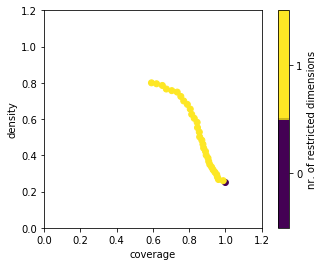

In [54]:
#the density/coverage trade-off found using prim
box1.show_tradeoff()
plt.show()

In [55]:
#inspecting the properties of the most promising box
box1.inspect()

coverage    0.592
density       0.8
mass        0.185
mean          0.8
res dim         1
Name: 31, dtype: object

             box 31                                     
                min       max                  qp values
A.3_pfail  0.000067  0.183919  [5.0786918633190823e-109]



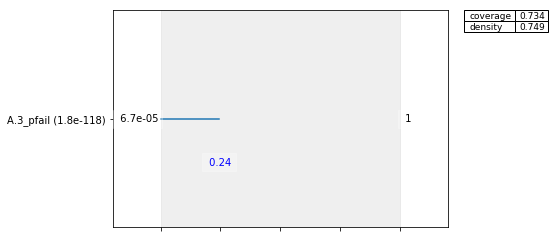

In [56]:
#inspection of which attributes of the policies have most impact
box1.inspect(26, style='graph')
plt.show()

In [72]:
policies_moro

[{'A.1_DikeIncrease': 0.0, 'A.2_DikeIncrease': 9.0, 'A.3_DikeIncrease': 0.0, 'A.4_DikeIncrease': 1.0, 'A.5_DikeIncrease': 1.0, '0_RfR': 0.0, '1_RfR': 1.0, '2_RfR': 0.0, '3_RfR': 1.0, '4_RfR': 1.0, 'EWS_DaysToThreat': 3.0, 'total investment': 1.0, 'annual damage': 1.0, 'expected death': 1.0, 'dike investment': 1.0, 'RfR Investment': 0.0, 'Evacuation Costs': 0.97999999999999998},
 {'A.1_DikeIncrease': 1.0, 'A.2_DikeIncrease': 0.0, 'A.3_DikeIncrease': 0.0, 'A.4_DikeIncrease': 0.0, 'A.5_DikeIncrease': 5.0, '0_RfR': 0.0, '1_RfR': 1.0, '2_RfR': 0.0, '3_RfR': 0.0, '4_RfR': 1.0, 'EWS_DaysToThreat': 0.0, 'total investment': 1.0, 'annual damage': 1.0, 'expected death': 0.68000000000000005, 'dike investment': 1.0, 'RfR Investment': 1.0, 'Evacuation Costs': 1.0},
 {'A.1_DikeIncrease': 10.0, 'A.2_DikeIncrease': 10.0, 'A.3_DikeIncrease': 0.0, 'A.4_DikeIncrease': 4.0, 'A.5_DikeIncrease': 1.0, '0_RfR': 0.0, '1_RfR': 1.0, '2_RfR': 0.0, '3_RfR': 1.0, '4_RfR': 1.0, 'EWS_DaysToThreat': 0.0, 'total investm

In [84]:
policy1 = {'A.1_DikeIncrease':0, 'A.2_DikeIncrease':9, 'A.3_DikeIncrease':0, 'A.4_DikeIncrease':1, 'A.5_DikeIncrease':1, '0_RfR':0, '1_RfR':1, '2_RfR':0, '3_RfR':1, '4_RfR':1, 'EWS_DaysToThreat':3}
policy2 = {'A.1_DikeIncrease':1, 'A.2_DikeIncrease':0, 'A.3_DikeIncrease':0, 'A.4_DikeIncrease':0, 'A.5_DikeIncrease':5, '0_RfR':0, '1_RfR':1, '2_RfR':0, '3_RfR':0, '4_RfR':1, 'EWS_DaysToThreat':0}
policy3 = {'A.1_DikeIncrease':10, 'A.2_DikeIncrease':10, 'A.3_DikeIncrease':0, 'A.4_DikeIncrease':4, 'A.5_DikeIncrease':1, '0_RfR':0, '1_RfR':1, '2_RfR':0, '3_RfR':1, '4_RfR':1, 'EWS_DaysToThreat':0}
policy4 = {'A.1_DikeIncrease':9, 'A.2_DikeIncrease':10, 'A.3_DikeIncrease':0, 'A.4_DikeIncrease':3, 'A.5_DikeIncrease':8, '0_RfR':1, '1_RfR':1, '2_RfR':0, '3_RfR':0, '4_RfR':1, 'EWS_DaysToThreat':0}
policy5 = {'A.1_DikeIncrease':0, 'A.2_DikeIncrease':0, 'A.3_DikeIncrease':0, 'A.4_DikeIncrease':5, 'A.5_DikeIncrease':0, '0_RfR':0, '1_RfR':1, '2_RfR':0, '3_RfR':1, '4_RfR':1, 'EWS_DaysToThreat':0}


In [102]:
outcomes

{'All Costs': array([  8.67082292e+08,   9.12251618e+08,   7.73681446e+08, ...,
          9.62186600e+08,   7.68184499e+08,   9.58721813e+08]),
 'Dike Investment Costs': array([ 96829796.72374889,  96829796.72374889,  96829796.72374889, ...,
          9357028.59022418,   9357028.59022418,   9357028.59022418]),
 'Expected Annual Damage': array([  1.75145151e+08,   2.20306375e+08,   8.17457439e+07, ...,
          3.57729572e+08,   1.63727470e+08,   3.54264785e+08]),
 'Expected Evacuation Costs': array([  7344.8932313 ,  15445.89950475,   5905.19516748, ...,
             0.        ,      0.        ,      0.        ]),
 'RfR Total Costs': array([  5.95100000e+08,   5.95100000e+08,   5.95100000e+08, ...,
          5.95100000e+08,   5.95100000e+08,   5.95100000e+08]),
 'Total Investment Costs': array([  6.91937142e+08,   6.91945243e+08,   6.91935702e+08, ...,
          6.04457029e+08,   6.04457029e+08,   6.04457029e+08]),
 'Total Number of Deaths': array([ 0.03238345,  0.06321376,  0.0180202

In [107]:
outcomes?

In [106]:
pol1 = outcomes("Policy_1", outcomes.to_dict('records')[0])

AttributeError: 'dict' object has no attribute 'to_dict'